In [1]:
import pandas as pd
import sys

from cdhtools.IHanalysis import *
from cdhtools.cdh_utils import readDSExport

import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'cdhtools'

In [ ]:
df_orig = readDSExport("Data-pxStrategyResult_pxInteractionHistory_20210101T010000_GMT.zip", path="../../data")

Importing: ../../data/Data-pxStrategyResult_pxInteractionHistory_20210101T010000_GMT.zip


In [ ]:
df = initial_prep(df_orig, referenceTime='pxOutcomeTime')

At first, take a look into the IH dataframe, explore the columns, outcome types and business structure

In [ ]:
df.head()

,pySubjectType,pxInteractionID,ControlGroupValidityStart,pyStage,pyJourney,CustomerID,ChannelSubGroup,pyChannel,pyCustomerSubSegment,pyStep,...,pyResponse,pyCategory,ControlGroupValidityEnd,pxDecisionTime,pyLabel,ChannelGroup,pyStrategy,Date,WeekOfYear,Week
0,CDHSample-Data-Customer,-3586780626931683381,,,,Customer-4118,,SMS,,,...,,,,2021-01-27 13:22:05.810000+00:00,U+ Personal Card,,InitializeModelsSmall,2021-01-27,4,1
1,CDHSample-Data-Customer,-3586780626931683381,,,,Customer-4118,,Web,,,...,,,,2021-01-27 13:22:05.810000+00:00,U+ Personal Card,,InitializeModelsSmall,2021-01-27,4,1
2,CDHSample-Data-Customer,-3586780626931683381,,,,Customer-4118,,Web,,,...,,,,2021-01-27 13:22:05.810000+00:00,Visa Gold Card,,InitializeModelsSmall,2021-01-27,4,1
3,CDHSample-Data-Customer,-3586780626931683381,,,,Customer-4118,,SMS,,,...,,,,2021-01-27 13:22:05.810000+00:00,MasterCard Gold,,InitializeModelsSmall,2021-01-27,4,1
4,CDHSample-Data-Customer,-3586780626931683381,,,,Customer-4118,,Web,,,...,,,,2021-01-27 13:22:05.810000+00:00,AMEXPersonal,,InitializeModelsSmall,2021-01-27,4,1


In [ ]:
df.groupby(['pyIssue', 'pyGroup', 'pyDirection', 'pyChannel', 'pyName', 'pyOutcome']).count()[[
    'pxInteractionID']].rename(columns={'pxInteractionID':'Count'})

Count
pyIssue pyGroup     pyDirection pyChannel pyName           pyOutcome        
                                                           Churned      5072
                                                           Loyal        4928
Sales   CreditCards Inbound     Web       AMEXPersonal     Clicked      1487
                                                           NoResponse   6331
                                          UPlusFinGold     Accepted      367
                                                           Rejected     6468
                                          UPlusFinPersonal Accepted      367
                                                           Rejected     6534
                                          UPlusGold        Accepted     1843
                                                           Clicked      1204
                                                           NoResponse   7004
                                                           Rejected     5487
                                          UPlusPersonal    Accept       2635
                                                           Accepted      970
                                                           Rejected     4361
                                          VisaGold         Clicked      1777
                                                           NoResponse   5538
                    Outbound    SMS       AMEXPersonal     Clicked      1002
                                                           NoResponse   6775
                                          MasterCardGold   Clicked       296
                                                           NoResponse   6438
                                          MasterCardWorld  Clicked       342
                                                           NoResponse   5846
                                          UPlusFinGold     Accepted      297
                                                           Clicked       265
                                                           NoResponse   7081
                                                           Rejected     6645
                                          UPlusFinPersonal Accepted      311
                                                           Rejected     6482
                                          UPlusGold        Accepted     1463
                                                           Rejected     5474
                                          UPlusPersonal    Accept       5206
                                                           Accepted      684
                                                           Clicked       581
                                                           NoResponse   4984
                                                           Rejected     4578

Use "plot_daily_accept_rate" to plot accept rate per day to understand how accept rates changed over time. To define accept rate, enter the positive (here: Accepted) and negative (here: Rejected) behaviour in the function. use kwargs to customize the graph. If the time ticks on the x axis are too many, shrink them using 'shrinkTicks'. If data is missing in certain days, force the graph make gaps for the missing days by setting 'allTime':True. you can also define hue

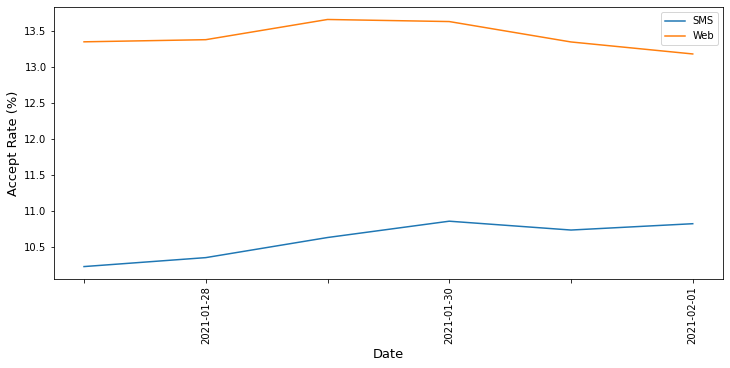

In [ ]:
plot_daily_accept_rate(df, 'Accepted', 'Rejected', 
                       **{'hue':['pyChannel'], 'allTime':True, 'shrinkTicks':True})

The above graph provides detailed metric behavior over time. Instead of Accept, you can use other outcome types. To get a rolled up view, plot the accept rate graph based on a weekly axis. The week values are calculated based on the starting date of the IH file

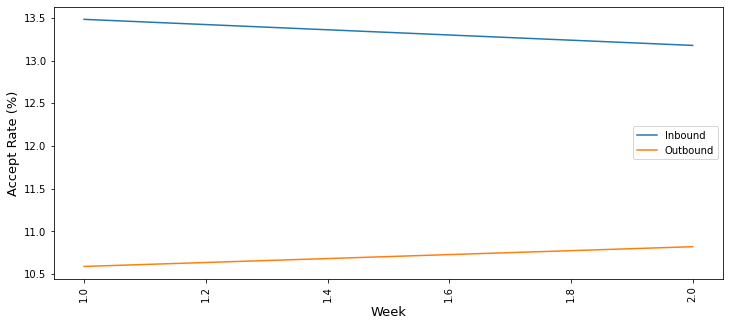

In [ ]:
plot_weekly_accept_rate(df, 'Accepted', 'Rejected', **{'showOutlier':True, 'hue':'pyDirection'})

The above graphs provide insight into the accept rates on daily or weekly basis. ADM models however, take all time data every update cycle, to generate bubble charts. To view the historical cumulative accept rate, use the function below. If choosing a single model, this graph will be as if you had ADM success rate captured over time. Set 'showOutlier' to True to view outlier values

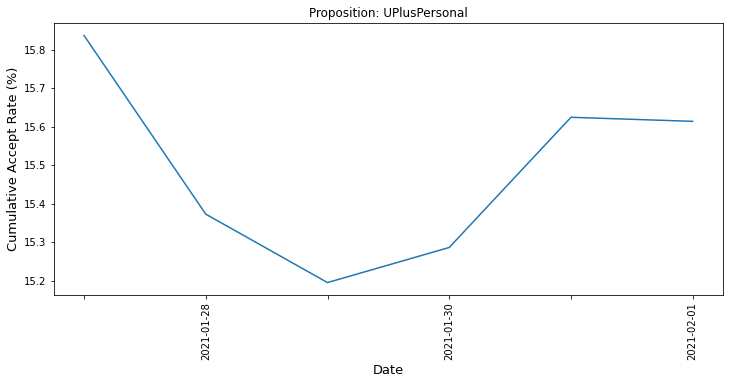

In [ ]:
plot_daily_cumulative_accept_rate(df[df['pyName']=='UPlusPersonal'], 'Accepted', 'Rejected', 
                                  **{'allTime':True, 'shrinkTicks':True, 'showOutlier':True,
                                     'title':'Proposition: UPlusPersonal'})

The above graph can be done in various granularity level. For example the below graph shows the cumulative accept rate over time across all the offers

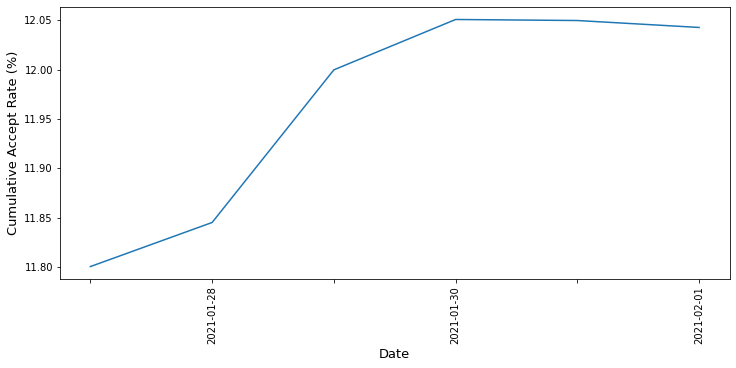

In [ ]:
plot_daily_cumulative_accept_rate(df, 'Accepted', 'Rejected', 
                                  **{'allTime':True, 'shrinkTicks':True, 'showOutlier':True})

Below graph shows the cumulative accept rate per pyGroup, pyDirection and pyChannel

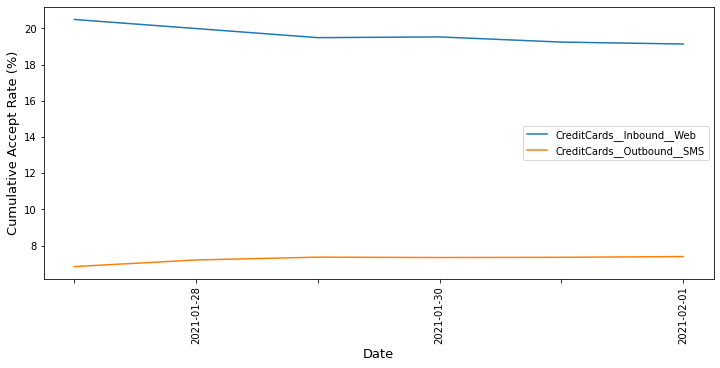

In [ ]:
plot_daily_cumulative_accept_rate(df, 'Clicked', 'NoResponse', 
                                  **{'hue':['pyGroup', 'pyDirection', 'pyChannel'], 
                                     'allTime':True, 'shrinkTicks':True})

In addition to accept rate, it is important to track other outcome values over time. Use 'daily' or 'weekly' to set the granularity of time axis. Instead of 'Accepted', other outcome labels can be explored over time

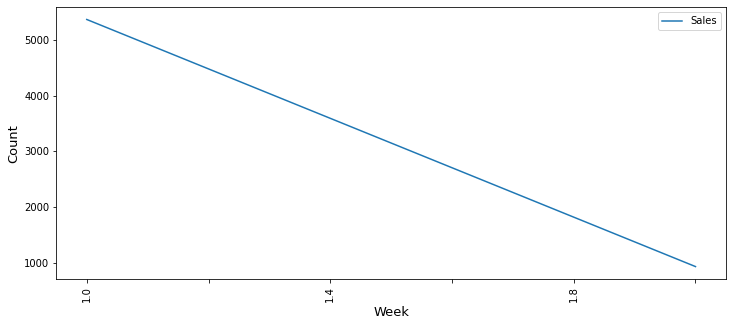

In [ ]:
plot_outcome_count_time(df, 'Accepted', 'weekly', **{'hue':'pyIssue', 'allTime':True, 'shrinkTicks':True})

below graphs puts a couple of graphs together to provide better insight at the offer level to be able to compare the accept rate, accept count and total responses per model

Text(0.5, 1.0, 'Offers within Inbound direction')

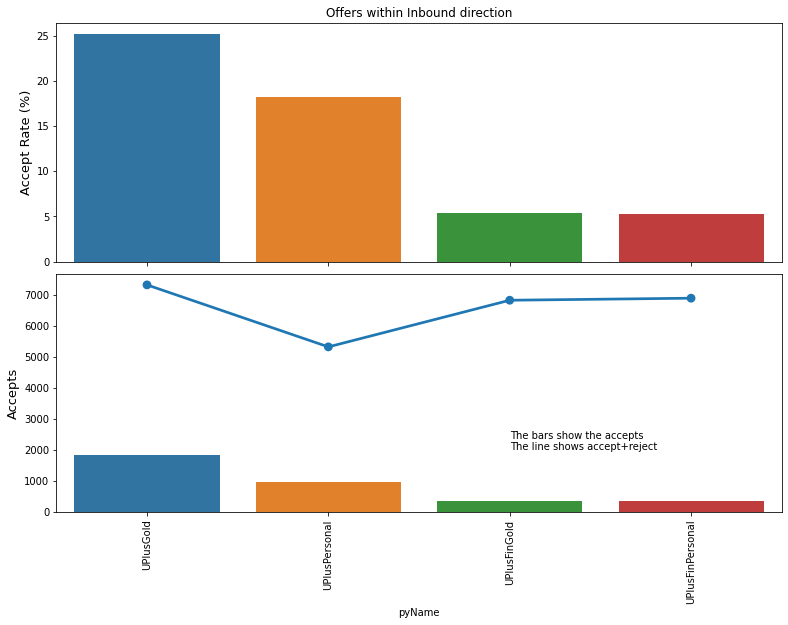

In [ ]:
plot_df = get_accept_rate(df[df['pyDirection']=='Inbound'], 'Accepted', 'Rejected', 'pyName')

fig, ax = plt.subplots(2,1,figsize=(13,9), sharex=True, gridspec_kw = {'hspace':0.05})
sort = plot_df.sort_values('Accept Rate (%)', ascending=False)['pyName'].tolist()
sns.barplot(x='pyName', y='Accept Rate (%)', data=plot_df, ax=ax[0], order=sort)
sns.barplot(x='pyName', y='Accepted', data=plot_df, ax=ax[1], order=sort)
sns.pointplot(x='pyName', y='Total', data=plot_df, ax=ax[1], order=sort)
for x in ax[1].get_xmajorticklabels():
    x.set_rotation(90)
ax[0].set_xlabel('')
ax[1].text(2,2000,'The bars show the accepts\nThe line shows accept+reject')
ax[0].set_ylabel('Accept Rate (%)', fontsize=13)
ax[1].set_ylabel('Accepts', fontsize=13)
ax[0].set_title('Offers within Inbound direction')

Another insightful graph is to see what share of a given outcome label, each offer(or direction or channel) has. For example the below graph shows that of all the historical 'Accepted' labels, 'UPlusGold' proposition has a little over 50% of all the 'Accepted' outcomes. 'UPlusFinPersonal' has roughly 10% of all time Accepted outcomes. instead of proposition level, you can set other levels (channel, direction etc).

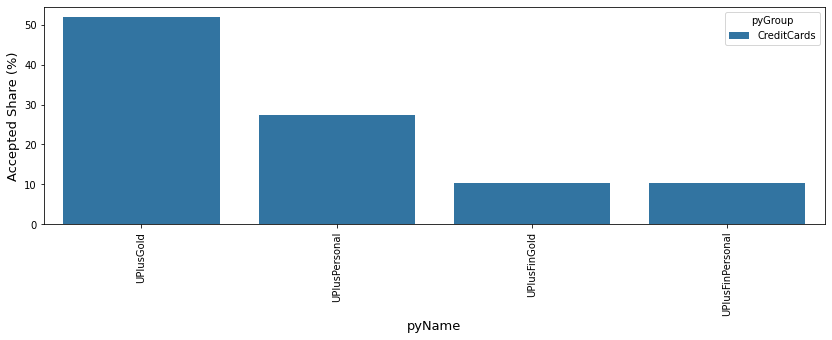

In [ ]:
plot_outcome_share_graph(df[df['pyChannel']=='Web'], 'Accepted', 'pyName', 'pyGroup')

It is also possible to see how the outcome share of a given proposition (or channel etc.) changed over time

In [ ]:
click_share_name_daily = get_outcome_share_time(df[df['pyChannel']=='Web'], 'Clicked', 'pyName', time='daily')
click_share_name_weekly = get_outcome_share_time(df[df['pyChannel']=='Web'], 'Clicked', 'pyName', time='weekly')

The graph below shows among offer within Web channel, what share of Clicked outcome labels belonged to UPlusGold proposition every day. It can be seen that the value dropped significantly on 12-23

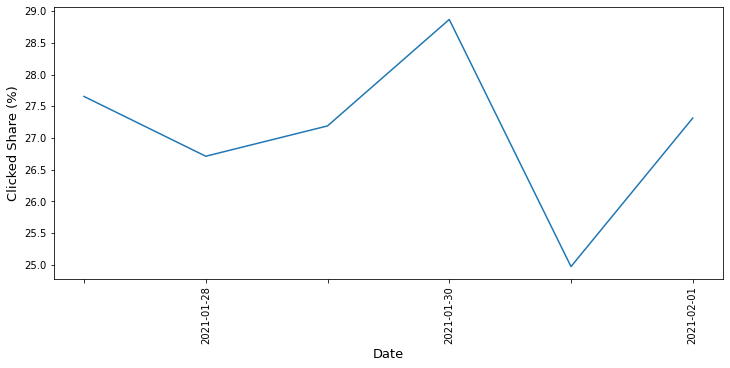

In [ ]:
get_daily_graph(click_share_name_daily[click_share_name_daily['pyName']=='UPlusGold'], 
                'Date', 'Clicked Share (%)', **{'shrinkTicks':True})

same graph can be viewed on a weekly basis

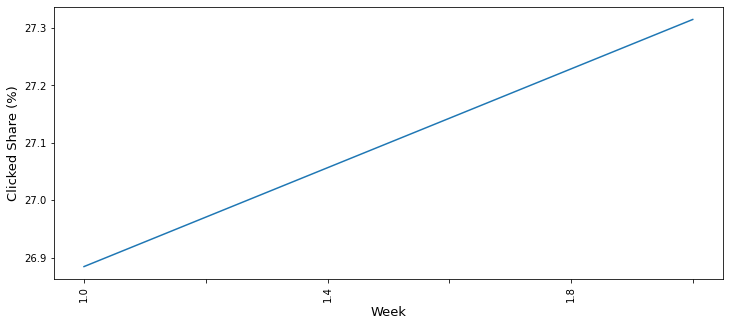

In [ ]:
get_daily_graph(click_share_name_weekly[click_share_name_weekly['pyName']=='UPlusGold'], 
                'Week', 'Clicked Share (%)', **{'shrinkTicks':True})

The graph below shows the Accepted share between two directions: Inbound/Outbound. Of course in this case because there are only 2 directions, when one graph goes up, the other has to go down so the sum of the two per day would be 100%

In [ ]:
click_share_direction_daily = get_outcome_share_time(df, 'Accepted', 'pyDirection', time='daily')

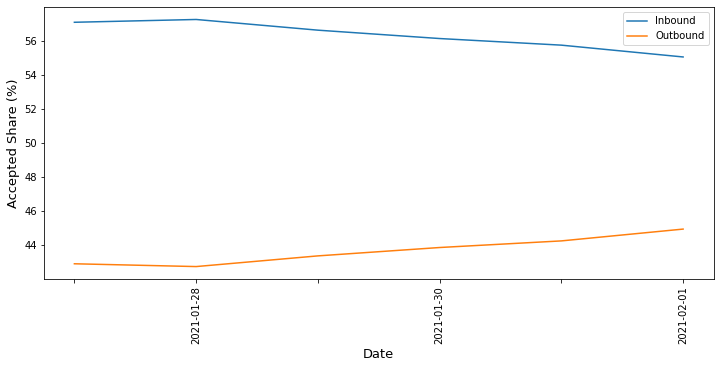

In [ ]:
get_daily_graph(click_share_direction_daily, 
                'Date', 'Accepted Share (%)', **{'shrinkTicks':True, 'hue':'pyDirection'})

The above graph can help identify how things evolve as a whole. It helps identify when the share for one direction (or channel etc.) goes down, which channel takes over goes down, which other 

same graph can be done for pyName as well. However, since there are usually so many pyNames, it would be hard to follow up and identify which offer had the highest share over time, and when an offer's share drops, which other offer takes over. So instead of looking over time, the below graph calculates a delta between the share percentage across two time frames. This is significanlty helpful when things in the strategy changes (priotitization, eligibility etc.) it helps identify how the system reacts once there is a change introduced.

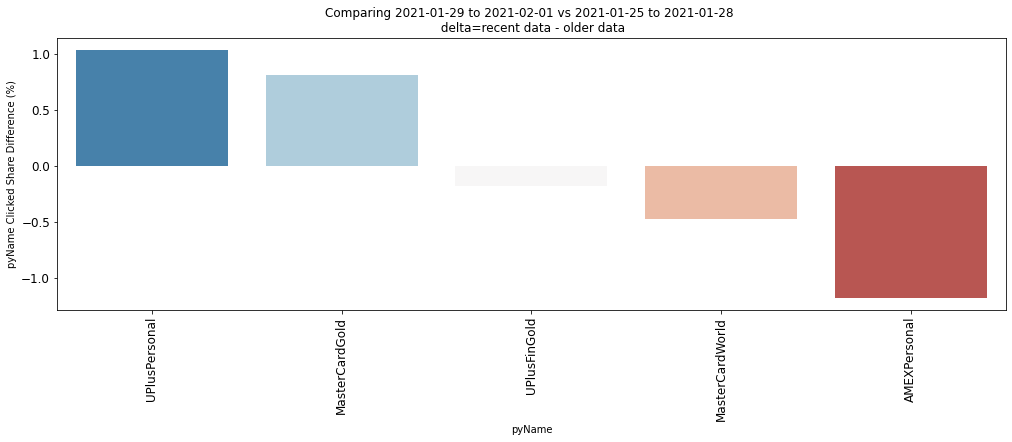

In [ ]:
plot_share_delta_graph(df[df['pyChannel']=='SMS'].reset_index(drop=True), 'Clicked', 'pyName', dates=4)

In the above graph, the clicked outcome shares for MasterCardGold has increased by 5% recently. The time range can be specified either by defining a lookback window (in that case only enter an integer) or by a list of two tuples where the first tuple represents the earlier time range and the second tuple represent the recent time range